In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import git
import mlflow.keras
import os, sys
import numpy as np
from gensim.models.wrappers import FastText

import tensorflow_hub as hub
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import *

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
%matplotlib inline
pd.set_option('display.max_rows', None)

sys.path.append('../citation_bio_trainer')
from Utils import calulate_ser_jer, load_from_folder, pad_sequences, load_embedding_matrix

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [4]:
path = '/home/joshib/cs_data/citation-bio-labelled-data-2020-06-08~15:13:57.766608/nlp/exps/output/2020-06-08~15:13:57.766608'
#data_df = pd.read_csv(path+'/data-2020-06-08~15:14:01.185827.csv')

## LSTM with random embedding model

In [5]:
%%time
train_data_path = '/nlp/cs_data_full/cs_data_train/'
test_data_path  = '/nlp/cs_data_full/cs_data_test/'
pattern = "*#*#*"
sentences_train, sent_tags_train = load_from_folder(train_data_path, pattern)
sentences_test, sent_tags_test = load_from_folder(test_data_path, pattern)

CPU times: user 2min 39s, sys: 1.91 s, total: 2min 41s
Wall time: 2min 41s


In [6]:
len_arr = [len(x.split(pattern)) for x in sentences_train+sentences_test]

In [7]:
print("Min: %d"%np.min(len_arr))
print("Max: %d"%np.max(len_arr))
print("Mean: %d"%np.mean(len_arr))
print("Median: %d"%np.median(len_arr))

Min: 26
Max: 7272
Mean: 1602
Median: 1543


In [8]:
%%time
maxlen = max(len_arr)
new_X_train, new_y_train = pad_sequences(sentences_train, sent_tags_train, maxlen, pattern)
new_X_test, new_y_test = pad_sequences(sentences_test, sent_tags_test, maxlen, pattern)

CPU times: user 2min 24s, sys: 4.88 s, total: 2min 29s
Wall time: 2min 29s


In [ ]:
new_X_, new_y_test = pad_sequences(sentences_test, sent_tags_test, maxlen, pattern)

In [9]:
%%time
tags2index = {'B-CIT': 1, 'I-CIT': 0}
new_y_train_enc = np.array([[tags2index[w] for w in s] for s in new_y_train])
new_y_test_enc = np.array([[tags2index[w] for w in s] for s in new_y_test])

CPU times: user 44.5 s, sys: 1.31 s, total: 45.8 s
Wall time: 45.8 s


In [10]:
embed_size = 300 # how big is each word vector
max_features = 100000 # how many unique words to use (i.e num rows in embedding vector)

In [11]:
### Subsample from full dataset
num_samples = 10000
new_X_train = new_X_train[0:num_samples]
new_y_train_enc = new_y_train_enc[0:num_samples]

In [12]:
X_train_orig, X_valid_orig, y_train, y_valid = train_test_split(new_X_train, new_y_train_enc, test_size=0.1, random_state=42)

tokenizer = Tokenizer(num_words=max_features, oov_token=1)
tokenizer.fit_on_texts(list(X_train_orig))
X_train  = np.array(tokenizer.texts_to_sequences(X_train_orig))
X_valid  = np.array(tokenizer.texts_to_sequences(X_valid_orig))
X_test   = np.array(tokenizer.texts_to_sequences(new_X_test))

In [13]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(9000, 7272)
(1000, 7272)
(7778, 7272)


## Keras with pre-trained fast text embedding

In [14]:
%%time
wiki_model = FastText.load_fasttext_format('/nlp/cc.en.300.bin')

CPU times: user 2min 44s, sys: 4.1 s, total: 2min 48s
Wall time: 2min 48s


In [15]:
%%time
embedding_matrix = load_embedding_matrix(wiki_model, max_features, tokenizer.word_index, 300)

Found 2000000 word vectors.
number of null word embeddings: 10215
CPU times: user 7.84 s, sys: 188 ms, total: 8.03 s
Wall time: 8.03 s


In [16]:
%%time
model = Sequential()
model.add(Embedding(max_features, 300, weights=[embedding_matrix], trainable=True, input_length= maxlen))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(1, activation="sigmoid")))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=Adam(
        learning_rate=0.001,
        beta_1=0.0,
        beta_2=0.0,
        epsilon=1e-05,
        amsgrad=False,
    ),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:820: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if (isinstance(inputs, collections.Sequence)
/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7272, 300)         30000000  
_________________________________________________________________
lstm (LSTM)                  (None, 7272, 50)          70200     
_________________________________________________________________
time_distributed (TimeDistri (None, 7272, 1)           51        
Total params: 30,070,251
Trainable params: 30,070,251
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1.19 s, sys: 577 ms, total: 1.77 s
Wall time: 1.18 s


In [17]:
class Metrics(callbacks.Callback):
    def __init__(self, train_data, validation_data):
        super(Metrics, self).__init__()
        self.validation_data = validation_data
        self.train_data = train_data
        
    def on_train_begin(self, logs={}):
        self.val_ser = []
        self.val_jer = []
        
    def on_epoch_end(self, epoch, logs):
        vx = self.validation_data[0]
        vy = self.validation_data[1]
        vx = np.array(vx)
        pred_y = None
        pred_y = self.model.predict(vx)
        py = np.argmax(pred_y, axis=-1)
        #vy = np.argmax(vy, axis=-1)
        vy = np.array(vy).flatten()
        py = np.array(py).flatten()
        ser, jer = calulate_ser_jer(vy, py)
        print(ser, jer)
        self.val_ser.append(ser)
        self.val_jer.append(jer)
        logs["val_ser"] = ser
        logs["val_jer"] = jer
        print(f"— val_ser: {ser} — val_jer: {jer}")
        return 

In [18]:
metrics = Metrics([X_train, y_train], [X_valid, y_valid])

Epoch 1/200


/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/training/tracking/data_structures.py:718: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):


141/141 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.99121.0 1.0
— val_ser: 1.0 — val_jer: 1.0
141/141 [==============================] - 122s 869ms/step - loss: 0.0501 - accuracy: 0.9912 - val_loss: 0.0170 - val_accuracy: 0.9927 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 2/200
141/141 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.99441.0 1.0
— val_ser: 1.0 — val_jer: 1.0
141/141 [==============================] - 121s 857ms/step - loss: 0.0138 - accuracy: 0.9944 - val_loss: 0.0096 - val_accuracy: 0.9976 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 3/200
141/141 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.99901.0 1.0
— val_ser: 1.0 — val_jer: 1.0
141/141 [==============================] - 121s 859ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0010 - val_accuracy: 0.9999 - val_ser: 1.0000 - val_jer: 1.0000
Epoch 4/200
141/141 [==============================] - ETA: 0s - loss: 4.6035e-04 - accuracy: 0.9

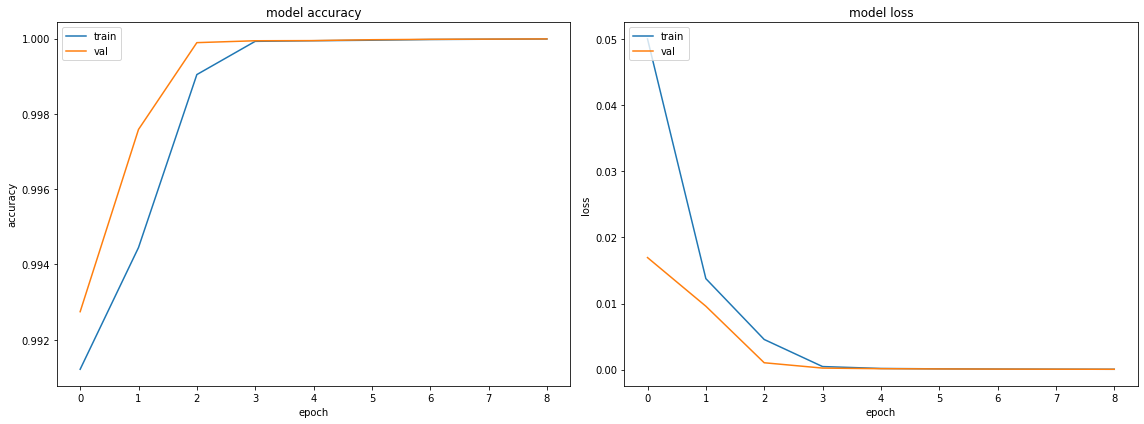

In [19]:
%%time
early_stop= EarlyStopping(monitor='val_loss',patience=3,verbose=0,mode='min',restore_best_weights=False, min_delta=0.0001)
history = model.fit(X_train, y_train, verbose=1, epochs=200, batch_size= 64, validation_data=(X_valid, y_valid), callbacks=[early_stop,metrics])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].title.set_text('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].title.set_text('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')
fig.tight_layout()

### Analysis on validation data

In [20]:
valid_probs = model.predict(X_valid)
valid_probs = valid_probs.reshape(valid_probs.shape[0], valid_probs.shape[1])
valid_preds = np.where(valid_probs > 0.5, 1, 0)

In [21]:
ser_jer  =  [calulate_ser_jer(i,j) for i,j in zip(y_valid, valid_preds)]
accuracy = [accuracy_score(i,j) for i,j in zip(y_valid, valid_preds)]

In [22]:
print("Mean SER: %0.6f"%np.mean([i[0] for i in ser_jer]))
print("Mean JER: %0.6f"%np.mean([i[1] for i in ser_jer]))
print("Mean Accuracy: %0.6f"%np.mean(accuracy))

Mean SER: 0.000247
Mean JER: 0.000885
Mean Accuracy: 0.999993


In [23]:
count_valid = 0
for ind in range(len(valid_preds)):
    pred = valid_preds[ind]
    true = y_valid[ind]
    if (true == pred).all():
        pass
    else:
        count_valid += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(fp_ind)
            print(ind, 'False positives:', fp_ind)
            for x in fp_ind:
                #print(x)
                print(np.array(X_valid_orig[ind])[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                print(np.array(X_valid_orig[ind])[max(0, x-3):x+4])

17 False negatives: [0]
['Chung,' 'Y.H.,' 'Färe,' 'R.,']
40 False positives: [1212]
['\n' '\n' '\n' 'G.V.' 'Samsonov,' 'The' 'oxide']
40 False negatives: [1211]
['\n' '\n' '\n' '\n' 'G.V.' 'Samsonov,' 'The']
48 False negatives: [0]
['Liang,' 'F.,' 'Chen,' 'X.,']
62 False negatives: [0]
['D.W.' 'Gong,' 'J.' 'Sun,']
64 False positives: [2]
['L.J.' '\n' 'Farrugia,' 'WINGX-version' '1.70.01,' 'single']
147 False negatives: [0]
['Cancer' 'Quality' 'Improvement' 'Program']
167 False negatives: [0]
['Jaber,' 'M.Y.' '(2011).' 'Learning']
218 False negatives: [0]
['M.S.' 'Aapro,' 'J.' 'Bohlius,']
301 False positives: [57]
['\n' '\n' '\n' 'Tl' 'reaction,' '2017.' '\n']
302 False negatives: [0]
['Research' 'Cell' 'Efficiency' 'Records.']
330 False positives: [2]
['1)' '\n' 'Y.' 'Sun,' 'L.' 'Wang,']
331 False positives: [561]
['\n' '\n' '\n' 'http://doi.org/10.7566/JPSCP.6.030126,' 'URL'
 'http://journals.jps.jp/doi/abs/10.7566/JPSCP.6.030126.' '\n']
344 False negatives: [0]
['Zhao,' 'Y.,' 'Feng,'

In [24]:
# for ind in range(5):
#     print(ind, np.array(X_valid_orig)[ind][np.where(y_valid[ind] == 1)])

In [25]:
print("%d mistakes out of total %d citations"%(count_valid, len(valid_preds)))

48 mistakes out of total 1000 citations


### Analysis of test result

In [26]:
test_probs = model.predict(X_test)
test_probs = test_probs.reshape(test_probs.shape[0], test_probs.shape[1])
test_preds = np.where(test_probs > 0.5, 1, 0)

In [27]:
ser_jer = [calulate_ser_jer(i,j) for i,j in zip(new_y_test_enc, test_preds)]
accuracy = [accuracy_score(i,j) for i,j in zip(new_y_test_enc, test_preds)]

In [28]:
print("Mean SER: %0.6f"%np.mean([i[0] for i in ser_jer]))
print("Mean JER: %0.6f"%np.mean([i[1] for i in ser_jer]))
print("Mean Accuracy: %0.6f"%np.mean(accuracy))

Mean SER: 0.000171
Mean JER: 0.000792
Mean Accuracy: 0.999994


In [29]:
count = 0
for ind in range(len(test_preds)):
    pred = test_preds[ind]
    true = new_y_test_enc[ind]
    if (true == pred).all():
        pass
    else:
        count += 1
        fp_ind = np.where((pred == 1) & (true == 0))[0]
        fn_ind = np.where((pred == 0) & (true == 1))[0]
        if len(fp_ind) > 0:
            #print(fp_ind)
            print(ind, 'False positives:', fp_ind)
            for x in fp_ind:
                #print(x)
                print(np.array(new_X_test[ind])[max(0, x-3):x+4])
        if len(fn_ind) > 0:
            print(ind, 'False negatives:', fn_ind)
            for x in fn_ind:
                print(np.array(new_X_test[ind])[max(0, x-3):x+4])

10 False negatives: [0]
['For' 'representative' 'chemical' 'synthesis']
14 False positives: [2]
['O’' '\n' 'Connor,' 'P.,' 'A' 'general']
32 False negatives: [0]
['de' 'Lange,' 'E.' 'C.']
35 False negatives: [0]
['OECD,' '2012.' '“The' 'jobs']
58 False negatives: [0]
['Global' 'review' 'of' 'rotavirus']
62 False positives: [2]
['XXX' '\n' '(n.d.-a).' '\n' '\n' '\n']
64 False positives: [253]
['\n' '\n' '\n'
 'mamatsu.com.cn/UserFiles/DownFile/Product/MCPassy_TMCP0001E1012345pdf\n'
 '(accessed' '05.05.2017).' '\n']
116 False negatives: [0]
['C.W.' 'Stewart,' 'C.L.' 'Wheeler,']
117 False negatives: [0]
['Health' 'MDo.' 'MIIC' 'and']
183 False negatives: [0]
['Masi,' 'M.D.' '(2011).' 'A']
211 False positives: [2]
['a)' '\n' 'Cressie,' 'N' '(1993).' 'Statistics']
264 False negatives: [0]
['Choi,' 'M.,' '&' 'Toma,']
282 False negatives: [0]
['Yang,' 'H.' 'and' 'Yang,']
285 False negatives: [0]
['Jose,' 'T.,' 'Pattanaik,' 'A.']
286 False negatives: [0]
['Liang' 'Z,' 'Chen' 'SL,']
295 False n

In [30]:
# for ind in range(5):
#     print(ind, np.array(new_X_test)[ind][np.where(new_y_test_enc[ind] == 1)])

In [31]:
print("%d mistakes out of total %d citations"%(count, len(test_preds)))

350 mistakes out of total 7778 citations


### Analysis on evaluation set (real-time dataset)

In [38]:
eval_df = pd.read_csv('/nlp/references_end_to_end_1613_piis_2019-9-13.csv')

In [39]:
eval_df.head(2)

,Unnamed: 0,submission_id,concatenated_s0_references,s_bibs_list,citations_eid,citations_doi
0,0,S0002961015004043,"1. Wang YR, Richter JE, Dempsey DT. Trends and...","[b'<ce:bib-reference xmlns:ce=""http://www.else...","['74049142845', '84879691268', '84873707457', ...","['10.1097/SLA.0b013e3181b975b8', '10.1007/s106..."
1,1,S0002961015004122,"1. Chang GJ, Rodriguez-Bigas MA, Skibber JM, M...","[b'<ce:bib-reference xmlns:ce=""http://www.else...","['34047245618', '35148861797', '36158699', '37...","['10.1093/jnci/djk092', '10.1080/0284186070120..."


In [25]:
# %%time
# model = Sequential()
# model.add(Embedding(max_features, embed_size, input_length=maxlen))
# model.add(Bidirectional(LSTM(512, return_sequences=True)))
# #model.add(Bidirectional(LSTM(100, return_sequences=True)))
# model.add(TimeDistributed(Dense(1, activation="sigmoid")))
# # # model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(
#         learning_rate=0.005,
#         beta_1=0.0,
#         beta_2=0.0,
#         epsilon=1e-05,
#         amsgrad=False,
#     ),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )
# model.summary()

In [26]:
#model.fit(X_train, y_train, verbose=1, epochs=5, validation_data=(X_test, y_test))

### Code check

In [35]:
# import pandas as pd
# import numpy as np
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import *
# import tensorflow as tf

# X = np.random.randint(1000, size=(10000, 80))
# y = np.random.choice([0,1], size=10000)

# model = Sequential()
# model.add(Embedding(1000, 50, input_length = 80))
# model.add(LSTM(10))
# model.add(Dense(1, activation='sigmoid'))
# print ('Compiling...')
# model.compile(loss='binary_crossentropy',
#               optimizer='sgd',
#               metrics=['accuracy'])
# print(model.summary())

In [214]:
#wiki_model['[']

In [42]:
temp_x = new_X_test[0:5]
temp_y = new_y_test_enc[0:5]

In [43]:
stops = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 'why', "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves']

In [44]:
temp_x_new = []
for sent in temp_x:
    sent_new = []
    for word in sent:
        if word == '\n':
            random.shuffle(stops)
            sent_new.append(stops[0])
        else:
            sent_new.append(word)
    temp_x_new.append(sent_new)

In [45]:
X_test_temp = np.array(tokenizer.texts_to_sequences(temp_x_new))

In [46]:
temp_probs = model.predict(X_test_temp)
temp_probs = temp_probs.reshape(temp_probs.shape[0], temp_probs.shape[1])
temp_preds = np.where(temp_probs > 0.5, 1, 0)

In [47]:
ser_jer = [calulate_ser_jer(i,j) for i,j in zip(temp_y, temp_preds)]
accuracy = [accuracy_score(i,j) for i,j in zip(temp_y, temp_preds)]

In [48]:
print("Mean SER: %0.6f"%np.mean([i[0] for i in ser_jer]))
print("Mean JER: %0.6f"%np.mean([i[1] for i in ser_jer]))
print("Mean Accuracy: %0.6f"%np.mean(accuracy))

Mean SER: 0.000000
Mean JER: 0.983388
Mean Accuracy: 0.991474


In [49]:
for ind in range(5):
    pred = temp_preds[ind]
    true = temp_y[ind]
    print(ind, len(np.where(pred == 1)[0]), len(np.where(true == 1)[0]), len(np.where((pred == 1) & (true == 0))[0]), len(np.where((pred == 0) & (true == 1))[0]))

0 1 47 0 46
1 1 65 0 64
2 1 79 0 78
3 1 75 0 74
4 1 49 0 48


In [50]:
len(np.where(temp_preds[0] ==1)[0])

1

In [112]:
temp.strip()

''

### Analysis on evaluation set (real-time production examples)

In [41]:
eval_df = pd.read_csv("/nlp/references_end_to_end_1613_piis_2019-9-13.csv")

In [42]:
eval_list = eval_df['concatenated_s0_references'].tolist()
sentences_eval = [i.split(" ") for i in eval_list]

In [47]:
#eval_X = [[w for w in s.split(" ")] for s in sentences_eval]
new_eval_X = []
for ind in range(len(sentences_eval)):
    new_seq = []
    for i in range(maxlen):
        try:
            new_seq.append(sentences_eval[ind][i])
        except:
            new_seq.append("PADword")
    new_eval_X.append(new_seq)

In [52]:
X_eval  = np.array(tokenizer.texts_to_sequences(new_eval_X))

In [54]:
eval_probs = model.predict(X_eval)
eval_probs = eval_probs.reshape(eval_probs.shape[0], eval_probs.shape[1])
eval_preds = np.where(eval_probs > 0.5, 1, 0)

/home/joshib/.cache/pypoetry/virtualenvs/dp-dpo-citation-bio-trainer-FaGiNfZ9-py3.7/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


In [55]:
eval_preds[0]

array([1, 0, 0, ..., 0, 0, 0])

In [57]:
for ind in range(len(X_eval)):
    print(np.where(eval_preds[ind] == 1))

(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array([0]),)
(array